In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install statsmodels

In [7]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pmdarima

     ------------------------------------ 615.0/615.0 kB 921.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt


In [10]:
# 1. Load data
df = pd.read_csv("Stocksastra.csv")
df['tanggal'] = pd.to_datetime(df['Tanggal'])
df = df[['tanggal', 'Terakhir']].dropna().rename(columns={'Terakhir': 'y'})
df = df.sort_values('tanggal').reset_index(drop=True)
df

,tanggal,y
0,2022-07-01,6.525
1,2022-07-04,6.500
2,2022-07-05,6.325
3,2022-07-06,6.075
4,2022-07-07,5.950
...,...,...
620,2025-01-22,4.960
621,2025-01-23,4.900
622,2025-01-24,4.870
623,2025-01-30,4.780


In [11]:
# 2. Uji Stasioneritas
result_adf = adfuller(df['y'])
result_kpss = kpss(df['y'], regression='c', nlags='auto')

print(f"ADF: Statistic={result_adf[0]}, p-value={result_adf[1]}")
print(f"KPSS: Statistic={result_kpss[0]}, p-value={result_kpss[1]}")


ADF: Statistic=-1.4889210457407471, p-value=0.5389846467862014
KPSS: Statistic=2.643369263034033, p-value=0.01


c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [12]:
# Differencing untuk membuat data stasioner
df['y_diff'] = df['y'].diff().dropna()

# Cek ulang stasioneritas
from statsmodels.tsa.stattools import adfuller, kpss

# Drop NA setelah differencing
series_diff = df['y_diff'].dropna()

# Uji ADF
adf_result = adfuller(series_diff)
print(f"ADF setelah differencing: Statistic={adf_result[0]}, p-value={adf_result[1]}")

# Uji KPSS
kpss_result = kpss(series_diff, regression='c', nlags='auto')
print(f"KPSS setelah differencing: Statistic={kpss_result[0]}, p-value={kpss_result[1]}")


ADF setelah differencing: Statistic=-18.815961888844377, p-value=2.0222955057364234e-30
KPSS setelah differencing: Statistic=0.04663229556874657, p-value=0.1


c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [4]:
# 3. Uji Stasioneritas
adf_result = adfuller(series['y'])
kpss_result = kpss(series['y'], regression='c', nlags='auto')

print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")
print(f"KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}")

ADF Statistic: -1.4889210457407471, p-value: 0.5389846467862014
KPSS Statistic: 2.643369263034033, p-value: 0.01


c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [13]:

# 4. Auto ARIMA
model = auto_arima(series['y'],
                   start_p=0, start_q=0,
                   max_p=5, max_q=5,
                   seasonal=False,
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1207.908, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1206.205, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1206.241, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1209.340, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1207.048, Time=0.69 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.286 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  625
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 605.670
Date:                Mon, 19 May 2025   AIC                          -1209.340
Time:                        14:41:51   BIC                          -1204.904
Sample:                             0   HQIC                         -1207.617
                                - 625                                  

In [14]:
# 5. Split train-test
train = series['y'][:-30]
test = series['y'][-30:]

# 6. Fit model dan prediksi
model_fit = model.fit(train)
forecast = model_fit.predict(n_periods=30)

c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
from itertools import product

# 4. Grid Search manual untuk ARIMA
train = df['y'][:-30]
test = df['y'][-30:]

p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

best_score = float('inf')
best_order = None
results = []

for order in product(p_values, d_values, q_values):
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=30)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        results.append((order, rmse))
        
        if rmse < best_score:
            best_score = rmse
            best_order = order
    except:
        continue

print(f"Best ARIMA order by grid search: {best_order} with RMSE: {best_score}")


c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\tsa\states

Best ARIMA order by grid search: (1, 1, 1) with RMSE: 0.32716402161602176


c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


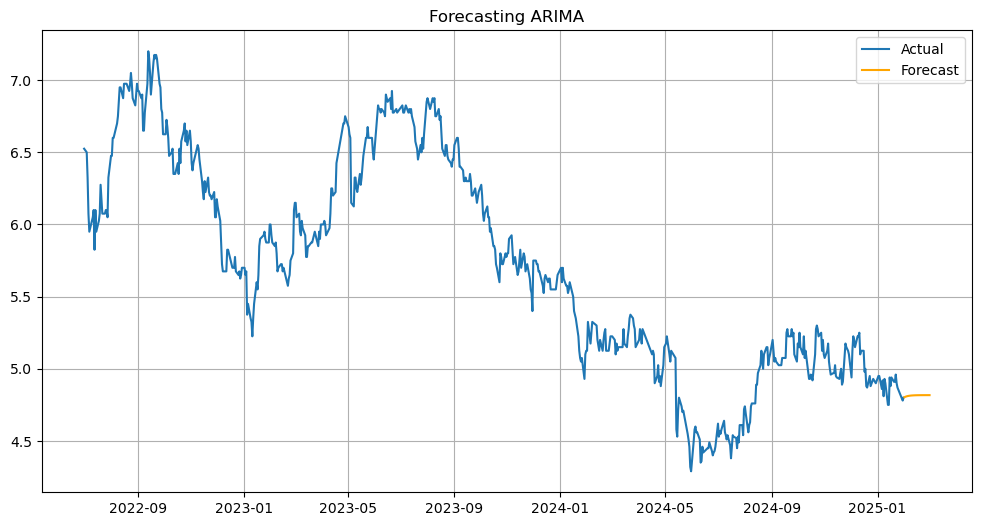

In [17]:
# 5. Final Forecasting with Best Model
model = ARIMA(df['y'], order=best_order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

forecast_dates = pd.date_range(start=df['tanggal'].iloc[-1] + pd.Timedelta(days=1), periods=30)
forecast_df = pd.DataFrame({'tanggal': forecast_dates, 'forecast': forecast})

# Plot hasil
plt.figure(figsize=(12, 6))
plt.plot(df['tanggal'], df['y'], label='Actual')
plt.plot(forecast_df['tanggal'], forecast_df['forecast'], label='Forecast', color='orange')
plt.title('Forecasting ARIMA')
plt.legend()
plt.grid()
plt.show()

In [18]:

# 6. Evaluasi jika data aktual tersedia
actual_test = df['y'][-30:].values
predicted_test = model_fit.forecast(steps=30)

rmse = np.sqrt(mean_squared_error(actual_test, predicted_test))
mape = mean_absolute_percentage_error(actual_test, predicted_test) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 0.1372
MAPE: 2.27%
